# Visualisation
By the end of this lecture on you will be able to:
- create charts from Polars with the internal `plot` method
- create charts from Polars with external plotting libraries
- understand how these libraries support Polars

We import Vegafusion along with Altair below. Vegafusion is not necessary but reduces the burden on your browser for visualising larger datasets. See my blog post here for more on this: https://www.rhosignal.com/posts/polars-and-altair/

Up-to-date versions of the visualisation libraries are typically required for maximum compatibility

In [1]:
import polars as pl

import hvplot as hv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import vegafusion as vf

# Enable vegafusion for Altair
vf.enable()

ModuleNotFoundError: No module named 'altair'

In [2]:
csv_file = 'data_titanic.csv'

In [3]:
df = pl.read_csv(csv_file)
df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Ow…","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. …","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Mis…","""female""",26.0,0,0,"""STON/O2. 31012…",7.925,null,"""S"""


We first look at whether we can pass a Polars `DataFrame` directly to each plotting library by creating a simple bar chart. Below we consider some other points to be aware of for working with each library from Polars.

## Bar chart

We begin by getting a count of the number of passengers in each passenger class. See the section of the course on Statistics and Aggregation for more on the methods used here.

In [4]:
passenger_class_counts_df = (
    df['Pclass']
    .value_counts()
    .sort("Pclass")
)
passenger_class_counts_df

Pclass,count
i64,u32
1,216
2,184
3,491


## Built-in plotting with hvPlot
A `DataFrame` has a built-in `.plot` method that passes the `DataFrame` to the hvPlot library

In [5]:
passenger_class_counts_df.plot.bar(
    x="Pclass",
    y="count"
)

:Bars   [Pclass]   (count)

hvPlot is a wrapper for an underlying plotting library. By default it uses the Bokeh library which produces interactive charts that include controls on the right to:
- add tooltips describing the data when we hover over them
- ability to pan and zoom
- a reset button to restore to the original view

In this example we do a scatter plot of Age vs Fare with colour by Pclass and control the width of the plot

In [6]:
(
    df
    .plot.scatter(
    x="Age",
    y="Fare",
    color="Pclass",    
    width=500
    )
)

:Scatter   [Age]   (Fare,Pclass)

However, the colour map used for `Pclass` is not very useful as it treats the `Pclass` integers as continuous numerical values rather than discrete categorical values (this is a common occurrence across different plotting libraries).

We get a better colormap by casting `Pclass` to string before plotting

In [7]:
(
    df
    .with_columns(
        pl.col("Pclass").cast(pl.Utf8)
    ).plot.scatter(
    x="Age",
    y="Fare",
    color="Pclass",    
    )
)

:Scatter   [Age]   (Fare,Pclass)

We can control the colormap used explicitly with the `cmap` argument. The colormaps available are set out here:https://holoviews.org/user_guide/Colormaps.html

Note that the colormap you choose has to match with the hvPlot plotting backend you are using (Bokeh by default).

### Setting the plotting backend
We can change the plotting backend with `hv.extension`. We don't run this cell here, however, as it leads to the Matplotlib/Seaborn plots below not rendering

In [8]:
hv.extension('matplotlib')

The available backends are:
- Bokeh
- Plotly
- Matplotlib

### Available plot types
The plot types available from `.plot` will evolve over time. We can see the list available at present by printing the methods using Python's `dir` function on `df.plot`

In [9]:
[el for el in dir(df.plot) if not el.startswith("_") ]

['area',
 'bar',
 'barh',
 'bivariate',
 'box',
 'dataset',
 'density',
 'errorbars',
 'explorer',
 'heatmap',
 'hexbin',
 'hist',
 'kde',
 'labels',
 'line',
 'ohlc',
 'paths',
 'points',
 'polygons',
 'scatter',
 'step',
 'table',
 'vectorfield',
 'violin']

We demonstrate some more of these below
### Line plot
We create a simple time-series `DataFrame` to make a line plot

:Curve   [time]   (value)
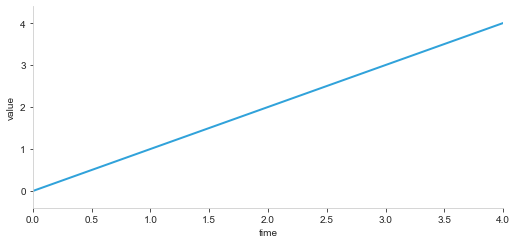

In [10]:
(
    pl.DataFrame(
        {
            "time":[0,1,2,3,4],
            "value":[0,1,2,3,4]
        }
    )
    .plot
    .line(
        x="time",
        y="value"
    )
)

### Histogram
We can make a histogram either from an expression

:Histogram   [Fare]   (Fare_count)
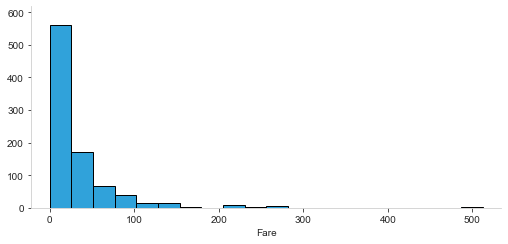

In [11]:
df.select("Fare").plot.hist()

or from a `Series`. In this example we set the number of bins

:Histogram   [Fare]   (Fare_count)
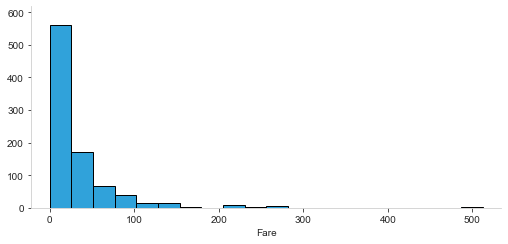

In [12]:
df["Fare"].plot.hist(bins=20)

## Plotting directly with external libraries
We can also pass a Polars `DataFrame` directly to external libraries.
### Matplotlib
We can pass the columns of the `passenger_class_counts_df` directly to Matplotlib

> I sometimes encounter problems with this chart and the Seaborn chart below not rendering. If you encounter this please let me know

In [13]:
plt.bar(
    x=passenger_class_counts_df["Pclass"],
    height=passenger_class_counts_df["count"]
)

<BarContainer object of 3 artists>

Note that the `Pclass` column is an integer column in Polars but the x-axis in the chart is a float axis. To make this appear as an categorical integer axis we cast the integers to strings

In [18]:
passenger_class_counts_string_column_df = (
    passenger_class_counts_df
    .with_columns(
        pl.col("Pclass").cast(pl.Utf8)
    )
)
plt.bar(
    x=passenger_class_counts_string_column_df["Pclass"],
    height=passenger_class_counts_string_column_df["count"]
)


<BarContainer object of 3 artists>

Matplotlib does not have explicit support for Polars. However, Matplotlib can accept a Polars `Series` as it just needs sequence-type objects that it can iterate through using standard python methods (that a `Series` supports).

### Seaborn
We can pass a Polars `DataFrame` to Seaborn for many charts. Note that Seaborn then typically copies the data to Pandas internally as it makes extensive use of Pandas-specific features such as the index. With a large `DataFrame` you may want to only pass the columns needed for the plot to avoid the whole `DataFrame` being copied!

In [19]:
sns.barplot(
    passenger_class_counts_df,
    x="Pclass",
    y="count"
)

AttributeError: 'DataFrame' object has no attribute 'get'

Some more complicated Seaborn charts also accept a Polars `DataFrame` directly such as `sns.scatterplot` or `sns.jointplot`. In this example we do a joint plot of (log) Age and (log) Fare coloured by passenger class

In [20]:
sns.jointplot(
    data=(
        df
        .with_columns(
            [
                pl.col(pl.Float64).log(),
                pl.col("Pclass").cast(pl.Utf8)
            ]
        )
    ),
    x="Age", 
    y="Fare", 
    hue="Pclass",
)

### Plotly
We can pass a `DataFrame` directly to Plotly - note that we again use the `DataFrame` with a string column for correct output (ignore any Pandas warnings from the Plotly internals)

In [ ]:
px.bar(
    passenger_class_counts_string_column_df,
    x="Pclass",
    y="count",
    color="Pclass",
    width=400
)

### The Dataframe Interchange Protocol
Seabornm Plotly and Altair below support Polars via the **Dataframe Interchange Protocol** ([read more here](https://data-apis.org/dataframe-protocol/latest/index.html)). This protocol is a way for 3rd-party packages (e.g. visualisation libraries) to work with different dataframe libraries without explicitly supporting the libraries.

What the use of the interchange protocol means in practice is that we can use Polars `DataFrames` directly with Plotly for many charts. However, as Polars does not have native support from Plotly there are no guarantees all plots will work with a Polars `DataFrame`. You may need to convert to Pandas in some cases.

If you are curious about how the interchange protocol works this is a simplified version:
- Plotly checks the type of the data object passed to it and finds that it is not a Pandas `DataFrame`
- Plotly then checks to see if the object passed to it has a `__dataframe__` namespace
- if Plotly finds the object has a `__dataframe__` namespace it uses the generic commands in that namespace to do what it needs (e.g. extract a named column from the `DataFrame`, check the dtype of the column and iterate through the column)

You can see the methods in the `__dataframe__` namespace on a Polars `DataFrame` here: 

In [ ]:
[el for el in dir(df.__dataframe__()) if not el.startswith("__")]

These methods are wrappers for the standard Polars methods we learn on this course. The dataframe interchange is a rapidly developing project in its own right and so expect functionality to grow.

### Altair
We can pass a `DataFrame` directly to Altair

In [ ]:
alt.Chart(
    passenger_class_counts_df,
    width=600
).mark_bar().encode(
    x="Pclass:N",
    y="count:Q",
    color="Pclass:N",
)

As with Plotly, Altair supports Polars via the Dataframe Interchange Protocol. The same caveats apply as for Plotly.

## Exercises
In the exercises you will develop your understanding of:
- creating charts from Polars

### Exercise 1
We first create a `DataFrame` of bike sales and replace spaces in the string column names with `_` (see the lecture on Transforming DataFrames in the section of selecting and transforming data for more on `pipe`)

In [ ]:
df_bike = (
    pl.read_parquet("../data/bike_sales.parquet")
    .pipe(lambda df: df.rename({col:col.replace(" ","_") for col in df.columns}))
)
df_bike.head(2)

We need to do a `group_by` first to get the data

In [ ]:
customer_count_df = (
    df_bike
    .group_by("customer_age")
    .len()
    .sort("customer_age")
)

Using the built-in plot method and your preferred visualisation library make a bar chart of the `customer_age` column showing the number of bikes sold by customer_age

<blank>

## Solutions

### hvPlot

In [ ]:
(
    customer_count_df
    .plot
    .bar(
    x="customer_age",
    y="len",
    width=1000
    )
)

### Matplotlib

In [ ]:
plt.bar(
    x=customer_count_df["customer_age"],
    height=customer_count_df["len"],
)

### Seaborn

In [ ]:
sns.barplot(
    customer_count_df.to_pandas(use_pyarrow_extension_array=True),
    x="customer_age",
    y="len"
)

### Plotly

In [ ]:
px.bar(
    customer_count_df.with_columns(pl.col("customer_age").cast(pl.Utf8)),
    x="customer_age",
    y="len",
)

### Altair

In [ ]:
(
    alt.Chart(
    customer_count_df,
        width=600
    )
    .mark_bar()
    .encode(
        x="customer_age:N",
        y="len:Q"
    )
)